# **Analisis dan Prediksi IHSG Menggunakan Pendekatan Time Series**

Tujuan :  membuat model yang dapat memprediksi IHSG yang memanfaatkan data historis sehingga dapat memberikan gambaran awal mengenai pergerakan indeks IHSG.


# Import Library

Instalisasi Library yang akan digunakan untuk mendukung proses analisis ini

In [1]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# Load and Understanding Data

Sumber dataseet IHSG : https://id.investing.com/indices/idx-composite

Dataset dimuat berikut:
- data_ihsg1 : dataset IHSG dari tahun 1990-2010
- data_ihsg2 : dataset IHSG dari tahun 2011- mei 2025

In [28]:
data_ihsg1 = pd.read_csv("https://raw.githubusercontent.com/ejapten/Predictive-Analysis-IHSG-TimeSeries/refs/heads/main/raw_dataset/1990_2010_IHSG.csv")
data_ihsg2 = pd.read_csv("https://raw.githubusercontent.com/ejapten/Predictive-Analysis-IHSG-TimeSeries/refs/heads/main/raw_dataset/2011_2025_IHSG%20.csv")


dataset digabungkan karena konteks data tersebut sama dan memudahkan untuk menganalisis data IHSG, dataset IHSG tersebut sama hanya saja periode waktu yang berbeda. Dataset yang digabungkan akan di-inisialisasi dengan data_ihsg agar mudah dalam tahap EDA

In [29]:
data_ihsg = pd.concat([data_ihsg1,data_ihsg2])
data_ihsg

,Date,Price,Open,High,Low,Vol.,Change %
0,09/28/2010,"3,472.71","3,468.23","3,524.32","3,455.50",6.18B,0.13%
1,09/27/2010,"3,468.04","3,397.82","3,472.03","3,397.82",6.05B,2.07%
2,09/24/2010,"3,397.63","3,338.71","3,400.56","3,331.86",4.98B,1.81%
3,09/23/2010,"3,337.20","3,343.83","3,351.39","3,313.31",7.51B,-0.18%
4,09/22/2010,"3,343.34","3,365.13","3,380.20","3,332.27",11.22B,-0.64%
...,...,...,...,...,...,...,...
3496,01/07/2011,"3,631.45","3,734.37","3,734.37","3,607.33",3.64B,-2.81%
3497,01/06/2011,"3,736.26","3,782.99","3,789.47","3,720.57",2.88B,-1.25%
3498,01/05/2011,"3,783.71","3,759.97","3,786.05","3,728.91",3.36B,0.63%
3499,01/04/2011,"3,760.06","3,727.80","3,763.38","3,724.47",5.31B,0.87%


In [30]:
data_ihsg.shape

(8500, 7)

data setelah dibersihkan berjumlah 7816 dan 3 variable

In [31]:
data_ihsg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8500 entries, 0 to 3500
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      8500 non-null   object
 1   Price     8500 non-null   object
 2   Open      8500 non-null   object
 3   High      8500 non-null   object
 4   Low       8500 non-null   object
 5   Vol.      7816 non-null   object
 6   Change %  8500 non-null   object
dtypes: object(7)
memory usage: 789.3+ KB


Setelah mengecek tipe data, ternyata semua variable bertipe data object

In [32]:
data_ihsg.isnull().sum()

,0
Date,0
Price,0
Open,0
High,0
Low,0
Vol.,684
Change %,0


Hanya variable Vol. saja yang memiliki Missing Value

In [33]:
data_ihsg.duplicated().sum()

np.int64(0)

Dalam data tersebut tidak memilik duplikat data

# Data Preparation

Dalamm proses load dan understading Data sudah dilakukan penggabungan data IHSG versi 1990-2010 dan vers 2011 - Mei 2025 menggunakan Concat. Oleh karena itu, daalam data preparation akan menggunakan data_ihsg yang sudah digabungkan dari penggabungan data IHSG versi 1990-2010 dan versi 2011 - Mei 2025. Atau  bisa inisalisasi ulang menggunakan concat

In [35]:
data_ihsg = pd.concat([data_ihsg1,data_ihsg2])
data_ihsg

,Date,Price,Open,High,Low,Vol.,Change %
0,09/28/2010,"3,472.71","3,468.23","3,524.32","3,455.50",6.18B,0.13%
1,09/27/2010,"3,468.04","3,397.82","3,472.03","3,397.82",6.05B,2.07%
2,09/24/2010,"3,397.63","3,338.71","3,400.56","3,331.86",4.98B,1.81%
3,09/23/2010,"3,337.20","3,343.83","3,351.39","3,313.31",7.51B,-0.18%
4,09/22/2010,"3,343.34","3,365.13","3,380.20","3,332.27",11.22B,-0.64%
...,...,...,...,...,...,...,...
3496,01/07/2011,"3,631.45","3,734.37","3,734.37","3,607.33",3.64B,-2.81%
3497,01/06/2011,"3,736.26","3,782.99","3,789.47","3,720.57",2.88B,-1.25%
3498,01/05/2011,"3,783.71","3,759.97","3,786.05","3,728.91",3.36B,0.63%
3499,01/04/2011,"3,760.06","3,727.80","3,763.38","3,724.47",5.31B,0.87%


Pada tahap Load dan Understanding Data, sudah mengetahui tuh apa saja yang harus dibersihkan, langkah selanjutnya adalah pembersihan data dan prepare data untuk modeling nanti

Membuat fungsi cleaning untuk membersihkan data:
- Tujuan pada analisis proyek ini adalah melihat pergerakan IHSG di masa depan berdasarkan Price atau Harga. Maka fitur selain Price dan Date akan dihapus
- Tidak akan menghapus missing value pada karena variabel Date dan Price tidak ada yg kosong, melainkan yang kosong ada pada variabel Vol. dimana variabel Vol. akan dihapus

In [36]:
# Fungsi menghapus variable/Kolom
def delete_columns(df, columns_to_delete):
  del_columns = df.drop(columns_to_delete, axis=1)
  return del_columns

#  Fungsi untuk konversi tipe data menjadi tanggal
def convert_to_datetime(df, col_name):
  df[col_name] = pd.to_datetime(df[col_name], format="%m/%d/%Y")
  return df
# Fungsi Untuk mengurutkan tanggal
def convert_and_sort_datetime(df, col_name):
  df[col_name] = pd.to_datetime(df[col_name], format="%m/%d/%Y")
  df = df.sort_values(by=col_name)
  df = df.reset_index(drop=True)
  return df

# Fungsi untuk konversi tipe data menjadi float dimana nilai unique sebelumnya bersifat
def convert_price_to_float(df, col_name):
  df[col_name] = df[col_name].str.replace(",", "").astype(float)
  return df

In [37]:
# Apply Fungsi Cleaning
columns_to_delete = ["Open", "High", "Low", "Vol.","Change %"] # Variable yang akan di delete

data_ihsg = delete_columns(data_ihsg, columns_to_delete)
data_ihsg = convert_to_datetime(data_ihsg, "Date")
data_ihsg = convert_and_sort_datetime(data_ihsg, "Date")
data_ihsg = convert_price_to_float(data_ihsg, "Price")

Fungsi cleaning diatas digunakan untuk membersihkan data
- Variable Open, High, Low, Vol., dan Change % akan dihapus karena tidak akan dilakukan proses analisis pada proyek kali ini. Namun, Price akan dilakukan analisis, dimana Price aka dijadikan sebagai variabel yang akan memprediksi pergerakan IHSG.

- Lalu dilakukan konversi tipe data menjadi datetime pada variabel Date dan diurutkan

Variable Price akan distandarisasikan dalam rentang 0 sampai 1 menggunakan Min-Max Scaling

In [40]:
scaler = MinMaxScaler()
data_ihsg["Price"] = scaler.fit_transform(data_ihsg[["Price"]])

Memuat price sebagai bentuk array dari variable Price

In [41]:
date = data_ihsg['Date'].values
price  =data_ihsg['Price'].values

Membuat data train dan data validasi untuk proses modelling dan mengevaluasi hasil model

In [42]:
# 80% untuk train dan 20% untuk validasi
split_time = int(len(price) * 0.8)
train_series = price[:split_time]
val_series = price[split_time:]

Membuat fungsi windowed_dataset_multi dimana Fungsi ini membagi data time series menjadi window input dan target output untuk keperluan pelatihan model multi-step forecasting.

In [43]:
def windowed_dataset_multi(series, window_size, output_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + output_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + output_size))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:window_size], w[window_size:]))
    return ds.batch(batch_size).prefetch(1)

Membentuk train_set dan val_set dengan window input 30 dan target output 60, dibagi dalam batch dan diacak agar siap digunakan untuk pelatihan model

In [44]:
window_size = 30
output_size = 60
batch_size=100
shuffle_buffer=1000

train_set = windowed_dataset_multi(train_series, window_size, output_size, batch_size, shuffle_buffer)
val_set = windowed_dataset_multi(val_series, window_size, output_size, batch_size, shuffle_buffer)

# Modelling

### LSTM without Tunning

In [45]:
# Membangun model LSTM untuk prediksi multi-step IHSG dengan 3 lapis layer
model_lstm = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(60),
])
# Optimizer Adam dengan learning rate kecil
optimizer = tf.keras.optimizers.Adam(learning_rate=1.0000e-04)

# dengan patience 5 akan mengehntikan training saat val_loss tidak membaik selama 5 epoch
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Simpan model terbaik berdasarkan val_loss
model_ckpt = ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Callback saat dipake pada training
callbacks = [early_stop, model_ckpt]

# Compile model dengan loss MSE dan metric MAE
model_lstm.compile(loss='mse', optimizer=optimizer, metrics=["mae"])

In [46]:
# training model

history_lstm = model_lstm.fit(train_set,validation_data=val_set, epochs=100, callbacks=callbacks)

Epoch 1/100
     68/Unknown 11s 67ms/step - loss: 0.0224 - mae: 0.0753

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.60245, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 0.0235 - mae: 0.0773 - val_loss: 0.6025 - val_mae: 0.7671
Epoch 2/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0179 - mae: 0.0635 
Epoch 2: val_loss improved from 0.60245 to 0.46094, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.0197 - mae: 0.0669 - val_loss: 0.4609 - val_mae: 0.6276
Epoch 3/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0167 - mae: 0.0813
Epoch 3: val_loss improved from 0.46094 to 0.32022, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - loss: 0.0179 - mae: 0.0834 - val_loss: 0.3202 - val_mae: 0.4896
Epoch 4/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0104 - mae: 0.0614
Epoch 4: val_loss improved from 0.32022 to 0.21764, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 0.0112 - mae: 0.0630 - val_loss: 0.2176 - val_mae: 0.3860
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0055 - mae: 0.0340
Epoch 5: val_loss improved from 0.21764 to 0.13821, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.0058 - mae: 0.0347 - val_loss: 0.1382 - val_mae: 0.2977
Epoch 6/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0029 - mae: 0.0246
Epoch 6: val_loss improved from 0.13821 to 0.08507, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 0.0032 - mae: 0.0257 - val_loss: 0.0851 - val_mae: 0.2323
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0018 - mae: 0.0216
Epoch 7: val_loss improved from 0.08507 to 0.05531, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - loss: 0.0019 - mae: 0.0220 - val_loss: 0.0553 - val_mae: 0.1915
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0011 - mae: 0.0199 
Epoch 8: val_loss improved from 0.05531 to 0.03638, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - loss: 0.0012 - mae: 0.0201 - val_loss: 0.0364 - val_mae: 0.1584
Epoch 9/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 7.7556e-04 - mae: 0.0188
Epoch 9: val_loss improved from 0.03638 to 0.02699, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 8.1967e-04 - mae: 0.0191 - val_loss: 0.0270 - val_mae: 0.1410
Epoch 10/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 6.0483e-04 - mae: 0.0172
Epoch 10: val_loss improved from 0.02699 to 0.02010, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 6.3180e-04 - mae: 0.0175 - val_loss: 0.0201 - val_mae: 0.1231
Epoch 11/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 5.2658e-04 - mae: 0.0167
Epoch 11: val_loss improved from 0.02010 to 0.01581, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - loss: 5.4397e-04 - mae: 0.0169 - val_loss: 0.0158 - val_mae: 0.1100
Epoch 12/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 4.4911e-04 - mae: 0.0153
Epoch 12: val_loss improved from 0.01581 to 0.01384, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 4.6354e-04 - mae: 0.0155 - val_loss: 0.0138 - val_mae: 0.1035
Epoch 13/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 4.2508e-04 - mae: 0.0151
Epoch 13: val_loss improved from 0.01384 to 0.01120, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 4.3689e-04 - mae: 0.0153 - val_loss: 0.0112 - val_mae: 0.0921
Epoch 14/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 3.9268e-04 - mae: 0.0142
Epoch 14: val_loss improved from 0.01120 to 0.00959, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - loss: 3.9834e-04 - mae: 0.0143 - val_loss: 0.0096 - val_mae: 0.0843
Epoch 15/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 3.7234e-04 - mae: 0.0140
Epoch 15: val_loss improved from 0.00959 to 0.00785, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 3.8250e-04 - mae: 0.0141 - val_loss: 0.0079 - val_mae: 0.0745
Epoch 16/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 3.2759e-04 - mae: 0.0126
Epoch 16: val_loss improved from 0.00785 to 0.00667, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 3.3257e-04 - mae: 0.0127 - val_loss: 0.0067 - val_mae: 0.0670
Epoch 17/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 3.4342e-04 - mae: 0.0132
Epoch 17: val_loss improved from 0.00667 to 0.00532, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 3.5299e-04 - mae: 0.0134 - val_loss: 0.0053 - val_mae: 0.0572
Epoch 18/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.9350e-04 - mae: 0.0119
Epoch 18: val_loss improved from 0.00532 to 0.00495, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 3.0356e-04 - mae: 0.0121 - val_loss: 0.0050 - val_mae: 0.0548
Epoch 19/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.9067e-04 - mae: 0.0117
Epoch 19: val_loss improved from 0.00495 to 0.00462, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 3.0045e-04 - mae: 0.0118 - val_loss: 0.0046 - val_mae: 0.0528
Epoch 20/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 2.6786e-04 - mae: 0.0112
Epoch 20: val_loss improved from 0.00462 to 0.00438, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 2.7779e-04 - mae: 0.0114 - val_loss: 0.0044 - val_mae: 0.0509
Epoch 21/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.9276e-04 - mae: 0.0115
Epoch 21: val_loss improved from 0.00438 to 0.00383, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 2.9740e-04 - mae: 0.0116 - val_loss: 0.0038 - val_mae: 0.0464
Epoch 22/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.6510e-04 - mae: 0.0110
Epoch 22: val_loss improved from 0.00383 to 0.00361, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - loss: 2.6980e-04 - mae: 0.0111 - val_loss: 0.0036 - val_mae: 0.0445
Epoch 23/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.5262e-04 - mae: 0.0105
Epoch 23: val_loss did not improve from 0.00361
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - loss: 2.6220e-04 - mae: 0.0107 - val_loss: 0.0038 - val_mae: 0.0474
Epoch 24/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.4799e-04 - mae: 0.0106
Epoch 24: val_loss improved from 0.00361 to 0.00345, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 2.5796e-04 - mae: 0.0108 - val_loss: 0.0034 - val_mae: 0.0435
Epoch 25/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 2.7636e-04 - mae: 0.0107
Epoch 25: val_loss improved from 0.00345 to 0.00312, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - loss: 2.8641e-04 - mae: 0.0109 - val_loss: 0.0031 - val_mae: 0.0402
Epoch 26/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.5976e-04 - mae: 0.0108
Epoch 26: val_loss improved from 0.00312 to 0.00302, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 2.6471e-04 - mae: 0.0108 - val_loss: 0.0030 - val_mae: 0.0391
Epoch 27/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.8584e-04 - mae: 0.0110
Epoch 27: val_loss improved from 0.00302 to 0.00293, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - loss: 2.9648e-04 - mae: 0.0111 - val_loss: 0.0029 - val_mae: 0.0384
Epoch 28/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 2.5267e-04 - mae: 0.0105
Epoch 28: val_loss did not improve from 0.00293
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - loss: 2.5732e-04 - mae: 0.0106 - val_loss: 0.0030 - val_mae: 0.0394
Epoch 29/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 2.4036e-04 - mae: 0.0102
Epoch 29: val_loss improved from 0.00293 to 0.00281, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 2.4983e-04 - mae: 0.0103 - val_loss: 0.0028 - val_mae: 0.0371
Epoch 30/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 2.6210e-04 - mae: 0.0108
Epoch 30: val_loss did not improve from 0.00281
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 2.7130e-04 - mae: 0.0110 - val_loss: 0.0030 - val_mae: 0.0395
Epoch 31/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.4757e-04 - mae: 0.0105 
Epoch 31: val_loss improved from 0.00281 to 0.00280, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 2.5226e-04 - mae: 0.0106 - val_loss: 0.0028 - val_mae: 0.0369
Epoch 32/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.2458e-04 - mae: 0.0118
Epoch 32: val_loss improved from 0.00280 to 0.00266, saving model to best_model_lstm.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 3.2990e-04 - mae: 0.0118 - val_loss: 0.0027 - val_mae: 0.0360
Epoch 33/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 2.5521e-04 - mae: 0.0110
Epoch 33: val_loss did not improve from 0.00266
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 2.5948e-04 - mae: 0.0111 - val_loss: 0.0027 - val_mae: 0.0362
Epoch 34/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.4344e-04 - mae: 0.0101 
Epoch 34: val_loss did not improve from 0.00266
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 2.4807e-04 - mae: 0.0102 - val_loss: 0.0027 - val_mae: 0.0366
Epoch 35/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.3530e-04 - mae: 0.0101
Epoch 35: val_loss did not improve from 0.00266
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - loss: 2.3986e-04 - mae: 0.0101 - val_loss: 0.0029 - val_mae: 0.0392
Epoch 36/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.3117e-04 - mae: 0.0099 
Epoch 36: val_loss improved from 0.00266 to 0.00264, saving mode

68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - loss: 2.4113e-04 - mae: 0.0101 - val_loss: 0.0026 - val_mae: 0.0357
Epoch 37/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.4452e-04 - mae: 0.0100
Epoch 37: val_loss did not improve from 0.00264
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - loss: 2.4919e-04 - mae: 0.0101 - val_loss: 0.0027 - val_mae: 0.0356
Epoch 38/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.9725e-04 - mae: 0.0113
Epoch 38: val_loss did not improve from 0.00264
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - loss: 3.0216e-04 - mae: 0.0113 - val_loss: 0.0027 - val_mae: 0.0359
Epoch 39/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.5666e-04 - mae: 0.0109
Epoch 39: val_loss did not improve from 0.00264
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - loss: 2.6567e-04 - mae: 0.0110 - val_loss: 0.0028 - val_mae: 0.0365
Epoch 40/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.5585e-04 - mae: 0.0105
Epoch 40: val_loss did not improve from 0.00264
68/68 ━━━━━━━━━━━

### LSTM With Tunning

In [47]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(
        hp.Int("lstm_units_1", min_value=32, max_value=128, step=32),
        return_sequences=True
    ))
    model.add(tf.keras.layers.LSTM(
        hp.Int("lstm_units_2", min_value=16, max_value=64, step=16)
    ))
    model.add(tf.keras.layers.Dense(
        hp.Int("dense_units", min_value=32, max_value=128, step=32),
        activation="relu"
    ))
    model.add(tf.keras.layers.Dense(output_size))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", [1e-4, 1e-3])
        ),
        loss="mse",
        metrics=["mae"]
    )

    return model


In [48]:
tuner = kt.GridSearch(
    build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=1,
    overwrite=True,
    directory="tuner_dir",
    project_name="ihsg_lstm"
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Simpan model terbaik berdasarkan val_loss
model_ckpt = ModelCheckpoint('best_model_lstm_with_tunnin.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [49]:
tuner.search(train_set, validation_data=val_set, epochs=50, callbacks=[early_stop])

Trial 3 Complete [00h 06m 08s]
val_loss: 0.003487484296783805

Best val_loss So Far: 0.002259552013128996
Total elapsed time: 00h 15m 17s


kode diatas adalah menjallankan proses pencarian hyperparameter terbaik untuk model yang telah dibuat oleh build_model()

In [50]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)
print("Best LSTM units 1:", best_hps.get("lstm_units_1"))
print("Best LSTM units 2:", best_hps.get("lstm_units_2"))
print("Best Dense units:", best_hps.get("dense_units"))
print("Best Learning rate:", best_hps.get("learning_rate"))


Best LSTM units 1: 32
Best LSTM units 2: 16
Best Dense units: 32
Best Learning rate: 0.001


Hasil hyperparamter terbaiik adalah
- Layer LSTM pertama menggunakan 32 neuron.
- Layer LSTM kedua menggunakan 16 neuron.
- Layer Dense menggunakan 32 neuron.
- Optimizer Adam menggunakan learning rate 0.001, yang lebih cepat daripada 0.0001, dan memberikan hasil terbaik.

In [51]:
history_lstm_with_tunning = best_model.fit(train_set, validation_data=val_set, epochs=100, callbacks = [early_stop, model_ckpt])


Epoch 1/100
     67/Unknown 9s 53ms/step - loss: 0.0029 - mae: 0.0297
Epoch 1: val_loss improved from inf to 0.01039, saving model to best_model_lstm_with_tunnin.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0030 - mae: 0.0303 - val_loss: 0.0104 - val_mae: 0.0840
Epoch 2/100
66/68 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0013 - mae: 0.0268
Epoch 2: val_loss improved from 0.01039 to 0.00410, saving model to best_model_lstm_with_tunnin.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 0.0041 - val_mae: 0.0503
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 7.2472e-04 - mae: 0.0210
Epoch 3: val_loss improved from 0.00410 to 0.00285, saving model to best_model_lstm_with_tunnin.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 7.2735e-04 - mae: 0.0210 - val_loss: 0.0028 - val_mae: 0.0384
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 5.2028e-04 - mae: 0.0178
Epoch 4: val_loss did not improve from 0.00285
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 5.2325e-04 - mae: 0.0179 - val_loss: 0.0029 - val_mae: 0.0399
Epoch 5/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.5948e-04 - mae: 0.0142
Epoch 5: val_loss did not improve from 0.00285
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 3.6786e-04 - mae: 0.0143 - val_loss: 0.0047 - val_mae: 0.0582
Epoch 6/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 2.8304e-04 - mae: 0.0117
Epoch 6: val_loss improved from 0.00285 to 0.00255, saving model to best_model_lstm_with_tunnin.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 2.9236e-04 - mae: 0.0119 - val_loss: 0.0026 - val_mae: 0.0349
Epoch 7/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.5500e-04 - mae: 0.0111
Epoch 7: val_loss did not improve from 0.00255
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 2.6364e-04 - mae: 0.0112 - val_loss: 0.0026 - val_mae: 0.0367
Epoch 8/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.2503e-04 - mae: 0.0101
Epoch 8: val_loss improved from 0.00255 to 0.00249, saving model to best_model_lstm_with_tunnin.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 2.3313e-04 - mae: 0.0102 - val_loss: 0.0025 - val_mae: 0.0345
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.1686e-04 - mae: 0.0094
Epoch 9: val_loss did not improve from 0.00249
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 2.2140e-04 - mae: 0.0095 - val_loss: 0.0039 - val_mae: 0.0464
Epoch 10/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.1554e-04 - mae: 0.0109
Epoch 10: val_loss improved from 0.00249 to 0.00237, saving model to best_model_lstm_with_tunnin.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 3.2785e-04 - mae: 0.0112 - val_loss: 0.0024 - val_mae: 0.0330
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 3.8616e-04 - mae: 0.0146
Epoch 11: val_loss improved from 0.00237 to 0.00235, saving model to best_model_lstm_with_tunnin.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 3.8964e-04 - mae: 0.0146 - val_loss: 0.0024 - val_mae: 0.0329
Epoch 12/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 3.8974e-04 - mae: 0.0154
Epoch 12: val_loss did not improve from 0.00235
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 3.9517e-04 - mae: 0.0154 - val_loss: 0.0025 - val_mae: 0.0342
Epoch 13/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 2.3450e-04 - mae: 0.0101
Epoch 13: val_loss did not improve from 0.00235
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 2.3871e-04 - mae: 0.0102 - val_loss: 0.0024 - val_mae: 0.0332
Epoch 14/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.7927e-04 - mae: 0.0121
Epoch 14: val_loss improved from 0.00235 to 0.00229, saving model to best_model_lstm_with_tunnin.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 2.8273e-04 - mae: 0.0121 - val_loss: 0.0023 - val_mae: 0.0325
Epoch 15/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.2194e-04 - mae: 0.0099
Epoch 15: val_loss did not improve from 0.00229
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 2.2579e-04 - mae: 0.0100 - val_loss: 0.0034 - val_mae: 0.0425
Epoch 16/100
66/68 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 2.3500e-04 - mae: 0.0099
Epoch 16: val_loss did not improve from 0.00229
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 2.4945e-04 - mae: 0.0101 - val_loss: 0.0028 - val_mae: 0.0370
Epoch 17/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.6146e-04 - mae: 0.0115
Epoch 17: val_loss improved from 0.00229 to 0.00224, saving model to best_model_lstm_with_tunnin.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 2.6842e-04 - mae: 0.0116 - val_loss: 0.0022 - val_mae: 0.0331
Epoch 18/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.1113e-04 - mae: 0.0099
Epoch 18: val_loss did not improve from 0.00224
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 2.1916e-04 - mae: 0.0100 - val_loss: 0.0025 - val_mae: 0.0343
Epoch 19/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.0305e-04 - mae: 0.0090
Epoch 19: val_loss did not improve from 0.00224
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 2.0694e-04 - mae: 0.0091 - val_loss: 0.0026 - val_mae: 0.0352
Epoch 20/100
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.9811e-04 - mae: 0.0092
Epoch 20: val_loss did not improve from 0.00224
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 2.0606e-04 - mae: 0.0094 - val_loss: 0.0034 - val_mae: 0.0432
Epoch 21/100
66/68 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.0874e-04 - mae: 0.0090
Epoch 21: val_loss did not improve from 0.00224
68/68 ━━━━━━━━━━━━━━

# Evaluasi  dan Result

### evaluasi

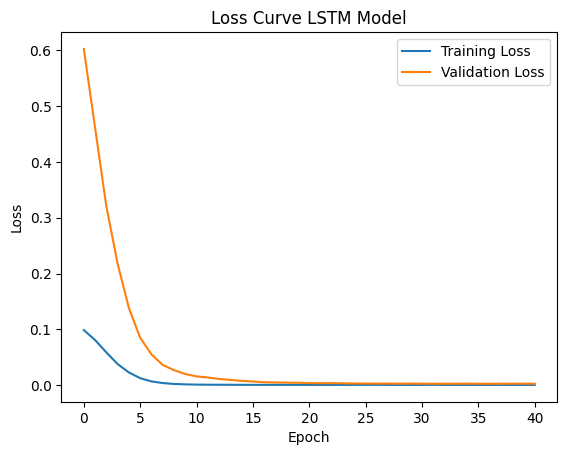

68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 2.7647e-04 - mae: 0.0115


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0029 - mae: 0.0363


In [65]:
# Melihat grafik kurva Loss
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve LSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Mengetahaui perbandingan skor train dan val
train_score_lstm = model_lstm.evaluate(train_set)
val_score_lstm = model_lstm.evaluate(val_set)


**Analisis Grafik:**
- Train dan validation loss sama sama turun dratis terus mendatar di nilai yang sangat kecil
- Tidak ada gap besar
- Validation loss sedikit lebih tinggi dari training loss, tapi polanya mengikuti dan stabil, tidak naik tajam di akhir epoch.

**Analisis Score:**
- nilai  loss dan mae pada training dan validasi sama sama kecil
- mae validasi sedikit lebih tinggi dari training tapi gap nya tidak besar
- Tidak ada tanda overfitting (yaitu training loss jauh lebih kecil dari validation loss).
- Tidak ada tanda underfitting (yaitu loss tidak turun atau tetap tinggi).

**Kesimpulan:**
- Model LSTM Tidak Overfitting dan Underfitting
- Model baik dan bisa digunakan untuk prediksi




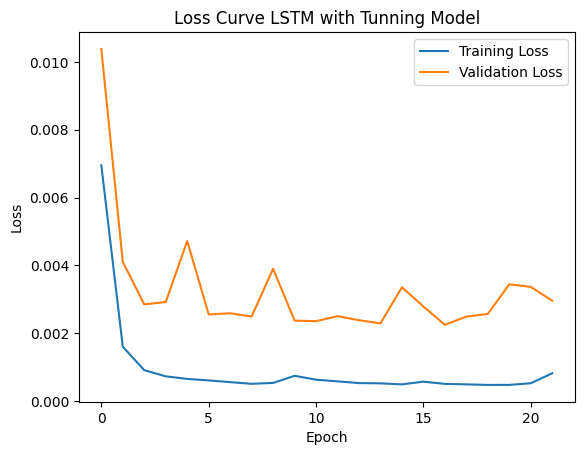

68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 2.4054e-04 - mae: 0.0109
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0023 - mae: 0.0330


In [53]:
# Melihat grafik kurva Loss
plt.plot(history_lstm_with_tunning.history['loss'], label='Training Loss')
plt.plot(history_lstm_with_tunning.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve LSTM with Tunning Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Mengetahaui perbandingan skor train dan val
train_score_lstm_tunning =best_model.evaluate(train_set)
val_score_lstm_tunning = best_model.evaluate(val_set)


**Analisis Grafik:**
- Train dan validation loss sama sama turun dengan cepaat
- Tidak ada gap besar
- Validation loss juga turun di awal, lalu fluktuasi dan lebih tinggi dari training loss.

**Analisis Score:**
- nilai  loss dan mae pada training dan validasi sama sama kecil
- mae validasi sedikit lebih tinggi dari training tapi gap nya tidak besar
- Tidak ada tanda overfitting (yaitu training loss jauh lebih kecil dari validation loss).
- Validation MAE juga masih cukup rendah.

**Kesimpulan:**
- Model LSTM Tidak Overfitting dan Underfitting
- Model baik dan bisa digunakan untuk prediksi




**Perbandingan**

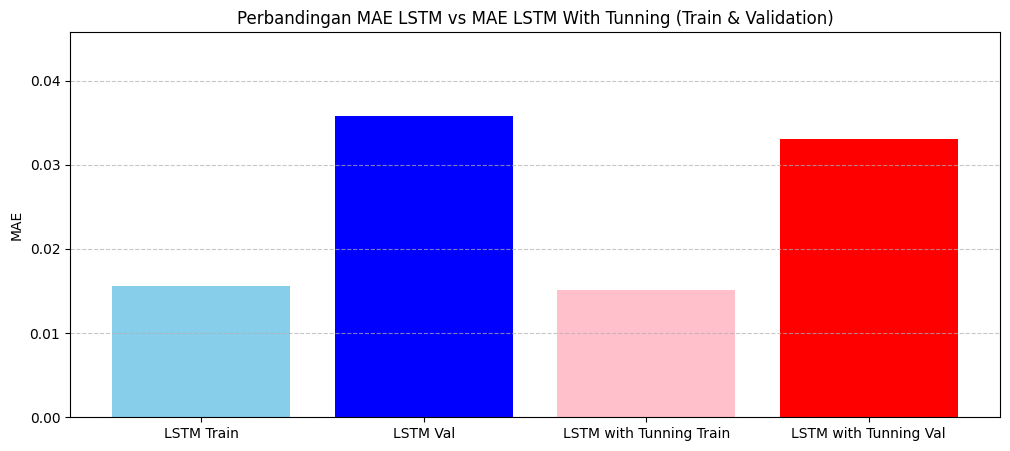

In [54]:
mae_scores = {
    'LSTM Train': train_score_lstm[1],
    'LSTM Val': val_score_lstm[1],
    'LSTM with Tunning Train': train_score_lstm_tunning[1],
    'LSTM with Tunning Val': val_score_lstm_tunning[1]
}

plt.figure(figsize=(12, 5))
plt.bar(mae_scores.keys(), mae_scores.values(), color=['skyblue', 'blue', 'pink', 'red'])
plt.ylabel('MAE')
plt.title('Perbandingan MAE LSTM vs MAE LSTM With Tunning (Train & Validation)')
plt.ylim(0, max(mae_scores.values()) + 0.01)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Model LSTM with Tunning memiliki MAE yang lebih rendah dari LSTM without tunning baik dari train dan validation. maka LSTM with Tunning model yang paling baik untuk prediksi

### Result

**Melakukan prediksi selama 60 hari kedepan**

In [55]:
# Ambil 60 data terakhir dari data asli (seluruh price yang sudah diskalakan)
last_window = price[-60:]
last_window = np.expand_dims(last_window, axis=(0, 2))

In [56]:
# Lakukan prediksi ke depan 60 hari menggunkan model cnn
future_pred_scaled = best_model.predict(last_window)
future_pred_scaled = future_pred_scaled.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


In [57]:
# Inverse hasil prediksi ke skala asli
future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1)).flatten()

In [58]:
# Buat range tanggal prediksi 60 hari ke depan
last_date = pd.to_datetime(data_ihsg["Date"].iloc[-1])
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 61)]

In [59]:
# Simpan hasil prediksi ke DataFrame
future_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_IHSG": future_pred
})

In [66]:
future_df.head(5)

,Date,Predicted_IHSG
0,2025-05-16,6830.041992
1,2025-05-17,6693.433105
2,2025-05-18,6695.544922
3,2025-05-19,6563.468262
4,2025-05-20,6710.425293


**Visualisasi Hasil**

In [61]:
# Inverse -- cukup 1x run
data_ihsg["Price"] = scaler.inverse_transform(data_ihsg[["Price"]])

In [62]:
# Ambil 60 hari terakhir data historis
historical_60 = data_ihsg.tail(60).copy()

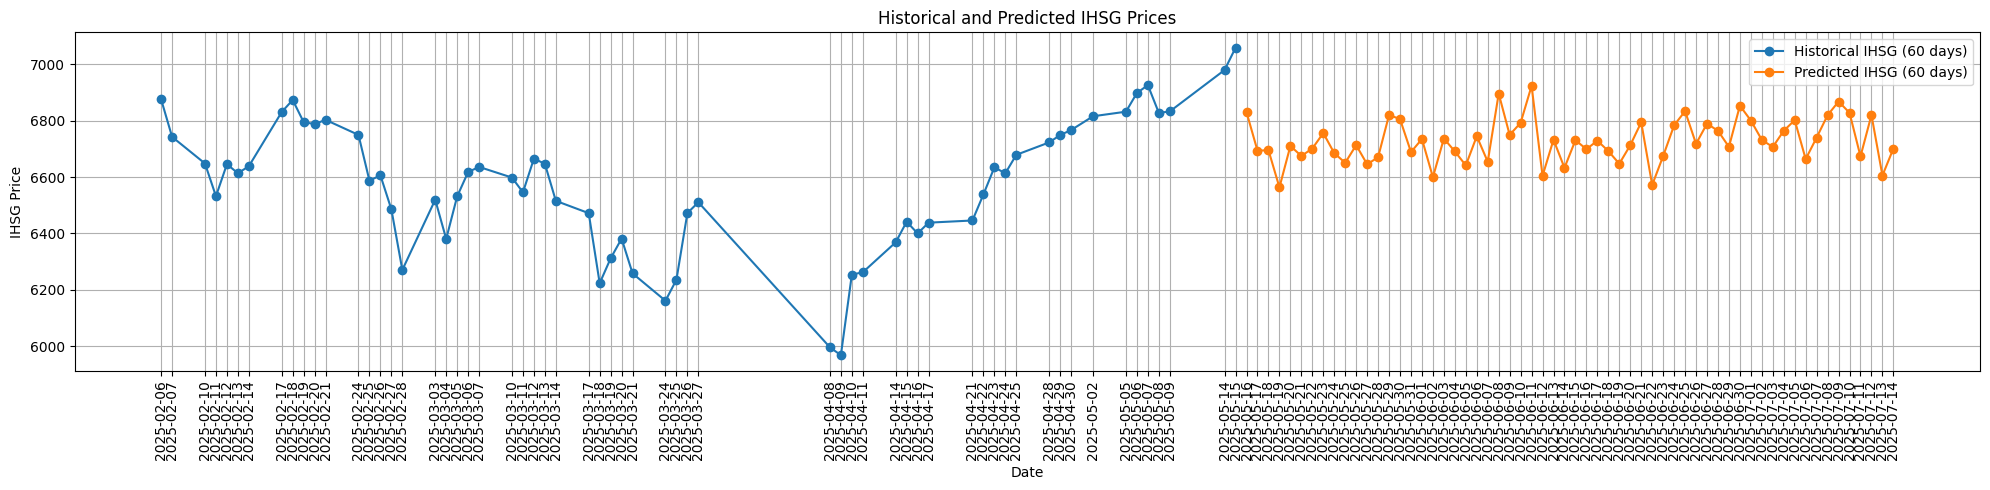

In [67]:
# Gabungkan semua tanggal (historis dan prediksi)
all_dates = pd.concat([historical_60['Date'], future_df['Date']])

plt.figure(figsize=(20, 5))
plt.plot(historical_60['Date'], historical_60['Price'], label='Historical IHSG (60 days)', marker='o')
plt.plot(future_df['Date'], future_df['Predicted_IHSG'], label='Predicted IHSG (60 days)', marker='o')

plt.xlabel('Date')
plt.ylabel('IHSG Price')
plt.title('Historical and Predicted IHSG Prices')
plt.legend()
plt.grid(True)

# Tampilkan semua tanggal pada sumbu X secara jelas
plt.xticks(ticks=all_dates, labels=all_dates.dt.strftime('%Y-%m-%d'), rotation=90)

plt.tight_layout()
plt.show()

pada line orange merupakan Hasil dari Prediksi selama 60 hari

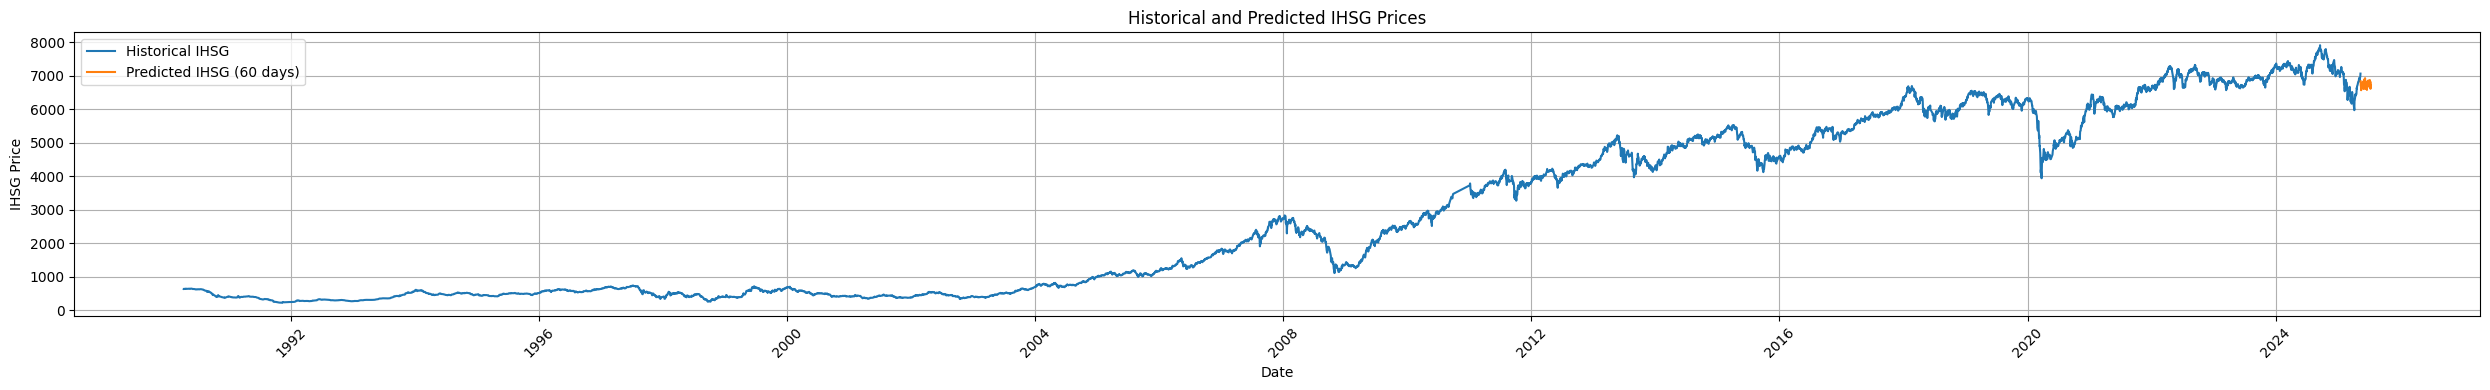

In [68]:
# Ambil 60 hari terakhir data historis (harga asli)
# historical_60 = data_ihsg.tail(60).copy()

# Data prediksi 60 hari ke depan sudah ada di future_df (kolom "Predicted_IHSG")
# Plot data historis dan prediksi
plt.figure(figsize=(25, 4))
plt.plot(data_ihsg['Date'], data_ihsg['Price'], label='Historical IHSG')
plt.plot(future_df['Date'], future_df['Predicted_IHSG'], label='Predicted IHSG (60 days)')
plt.xlabel('Date')
plt.ylabel('IHSG Price')
plt.title('Historical and Predicted IHSG Prices')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()